# Dynamic tuning

In [1]:
%cd ..

D:\Projects\Python\Euro-NeurIPS-2022


In [2]:
import glob
import itertools

import pandas as pd
from scipy import stats
import tomli

import tools

In [3]:
def res2data(where: str):
    with open(where, "r") as fh:
        data = fh.readlines()

    seed = int(where.split("-")[-1].removesuffix(".txt"))
    data = data[3:-5]  # remove headers and aggregate rows
    rows = [datum.strip().split() for datum in data]
    return [
        (inst, seed, int(cost), int(iters), tools.name2size(inst))
        for inst, feas, cost, iters, _ in rows
        if feas == "Y"
    ]

def size2group(size: int):
    if size < 300:
        return "small"
    elif 300 <= size <= 500:
        return "medium"
    else:
        return "large"

def read(group: str, exp: int):
    instances = glob.glob(f"data/tune/{group}/res-{exp}-*.txt")
    records = itertools.chain.from_iterable([res2data(inst) for inst in instances])

    df = pd.DataFrame(records, columns=["instance", "seed", "cost", "iters", "size"])
    df["size_group"] = df["size"].apply(size2group)
    df["exp"] = exp

    with open(f"data/tune/{group}/{exp}.toml", "rb") as fh:
        static_config = tomli.load(fh)

    for param, value in static_config["static"]["params"].items():
        df[param] = value
    
    return df

## Simulation solver

This section is about tuning the simulation solver, that is, the static solver used to solve the simulation instances. Those runs are typically *fast*, taking only half a second or less.

### Penalty parameters

This part is about the penalty parameters for the simulation solver.

In [4]:
dfs = [read("sim_penalty", exp) for exp in range(1, 101)]
df = pd.concat(dfs)
df.head()

,instance,seed,cost,iters,size,size_group,exp,initialTimeWarpPenalty,nbPenaltyManagement,feasBooster,penaltyIncrease,penaltyDecrease,targetFeasible,repairProbability,repairBooster
0,ORTEC-VRPTW-ASYM-a9d4edc2-d1-n200-k15,1,158845,65,200,small,1,25,1,2.0,1.2,0.25,0.4,0,10
1,ORTEC-VRPTW-ASYM-ef7dad5e-d1-n200-k12,1,130909,100,200,small,1,25,1,2.0,1.2,0.25,0.4,0,10
2,ORTEC-VRPTW-ASYM-9016f313-d1-n200-k20,1,188429,74,200,small,1,25,1,2.0,1.2,0.25,0.4,0,10
3,ORTEC-VRPTW-ASYM-fd32ebe8-d1-n201-k15,1,142934,70,201,small,1,25,1,2.0,1.2,0.25,0.4,0,10
4,ORTEC-VRPTW-ASYM-8512fc31-d1-n201-k20,1,170195,107,201,small,1,25,1,2.0,1.2,0.25,0.4,0,10


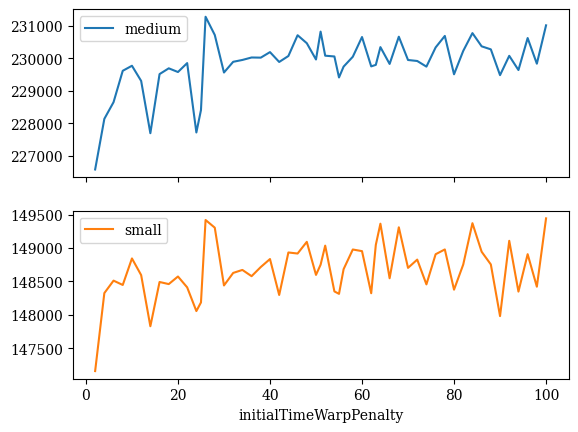

In [5]:
df.cost.groupby([df["initialTimeWarpPenalty"], df["size_group"]]).mean().unstack().plot(subplots=True);

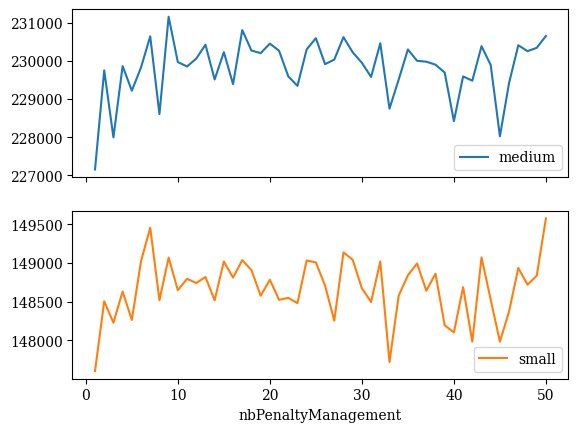

In [6]:
df.cost.groupby([df["nbPenaltyManagement"], df["size_group"]]).mean().unstack().plot(subplots=True);

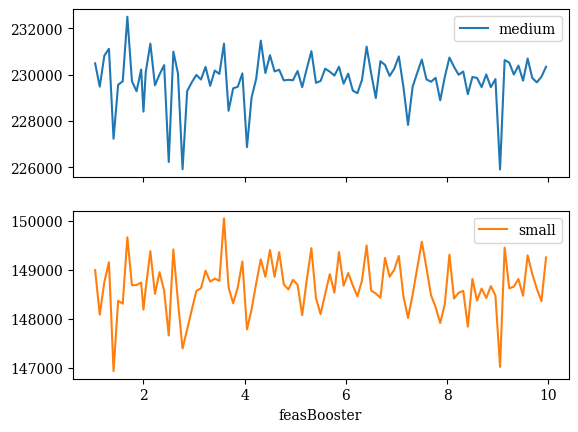

In [7]:
df.cost.groupby([df["feasBooster"], df["size_group"]]).mean().unstack().plot(subplots=True);

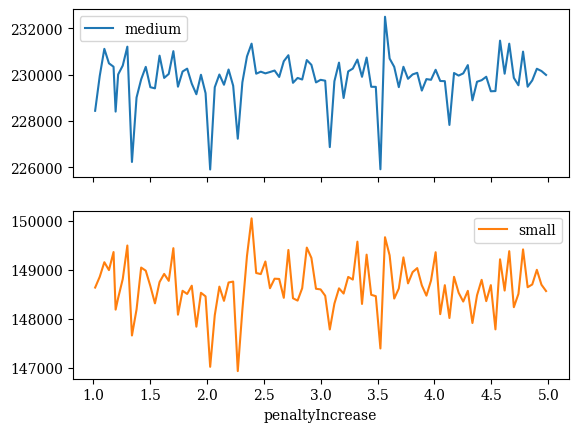

In [8]:
df.cost.groupby([df["penaltyIncrease"], df["size_group"]]).mean().unstack().plot(subplots=True);

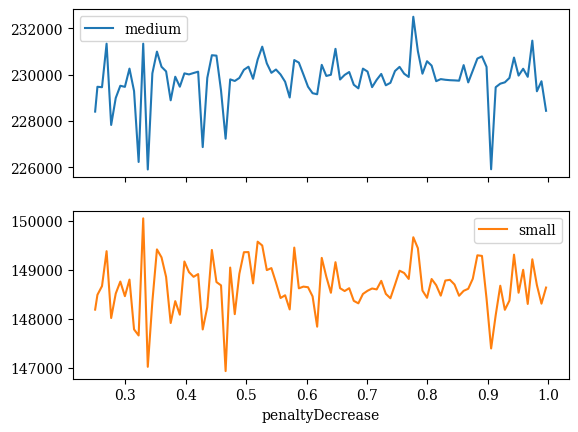

In [9]:
df.cost.groupby([df["penaltyDecrease"], df["size_group"]]).mean().unstack().plot(subplots=True);

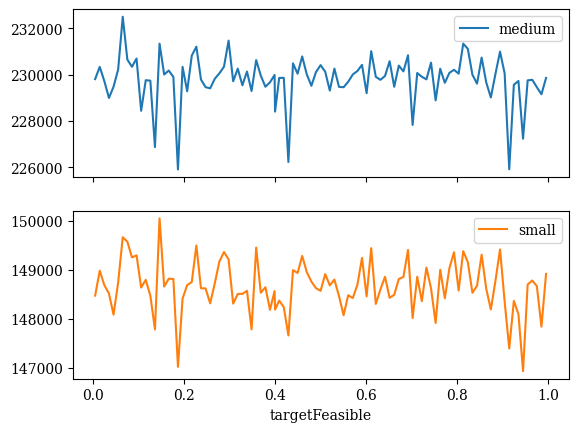

In [10]:
df.cost.groupby([df["targetFeasible"], df["size_group"]]).mean().unstack().plot(subplots=True);

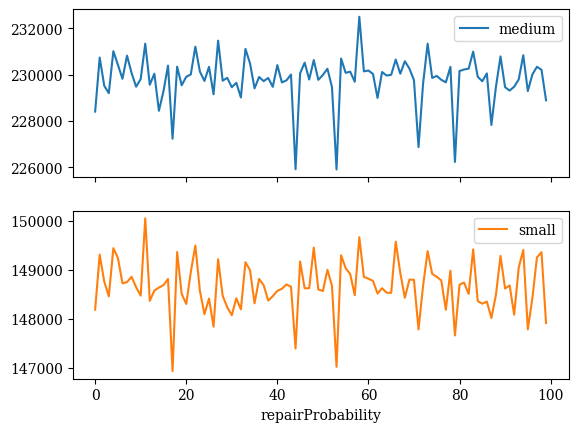

In [11]:
df.cost.groupby([df["repairProbability"], df["size_group"]]).mean().unstack().plot(subplots=True);

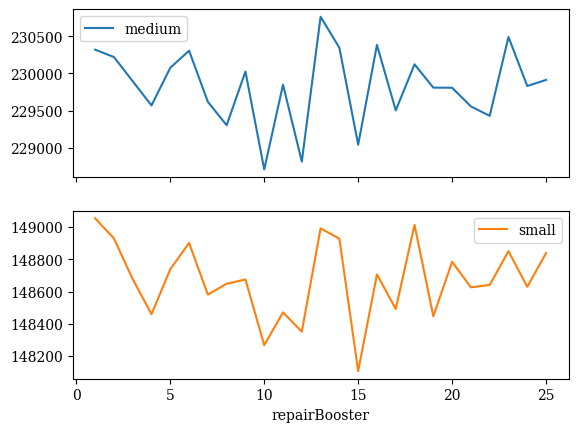

In [12]:
df.cost.groupby([df["repairBooster"], df["size_group"]]).mean().unstack().plot(subplots=True);

Is there any significant improvement?

In [13]:
mean_value = df[df.exp == 1].cost.mean()

for exp in range(1, 101):
    data = df[df.exp == exp]
    test = stats.ttest_1samp(data.cost, mean_value, alternative='less')
    mean = data.cost.mean()

    if mean <= mean_value:
        print(f"{exp:>3}  {test.pvalue:.2f}  {mean:.0f}")

  1  0.50  187955
  9  0.21  186990
 44  0.38  187582
 50  0.13  186610
 53  0.07  186125
 67  0.09  186320
 72  0.20  186740


### Population parameters

For the simulation solver.

In [14]:
dfs = [read("sim_population", exp) for exp in range(1, 101)]
df = pd.concat(dfs)
df.head()

,instance,seed,cost,iters,size,size_group,exp,minPopSize,generationSize,initialTimeWarpPenalty,nbPenaltyManagement,feasBooster,penaltyIncrease,penaltyDecrease,targetFeasible,repairProbability,repairBooster
0,ORTEC-VRPTW-ASYM-a9d4edc2-d1-n200-k15,1,166513,309,200,small,1,1,2,14,1,9.045455,2.030303,0.337121,0.186869,53,10
1,ORTEC-VRPTW-ASYM-ef7dad5e-d1-n200-k12,1,132271,113,200,small,1,1,2,14,1,9.045455,2.030303,0.337121,0.186869,53,10
2,ORTEC-VRPTW-ASYM-9016f313-d1-n200-k20,1,185746,87,200,small,1,1,2,14,1,9.045455,2.030303,0.337121,0.186869,53,10
3,ORTEC-VRPTW-ASYM-fd32ebe8-d1-n201-k15,1,151406,312,201,small,1,1,2,14,1,9.045455,2.030303,0.337121,0.186869,53,10
4,ORTEC-VRPTW-ASYM-8512fc31-d1-n201-k20,1,170940,157,201,small,1,1,2,14,1,9.045455,2.030303,0.337121,0.186869,53,10


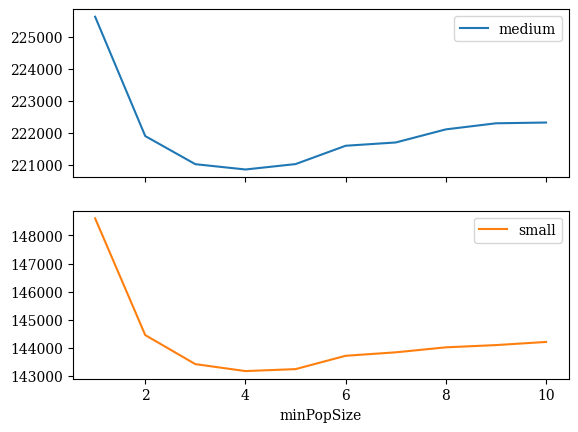

In [15]:
df.cost.groupby([df["minPopSize"], df["size_group"]]).mean().unstack().plot(subplots=True);

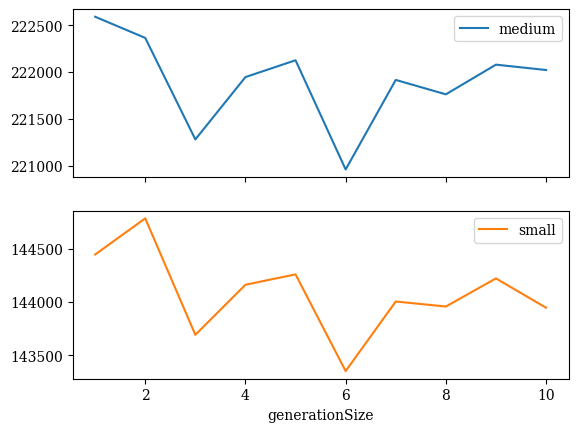

In [16]:
df.cost.groupby([df["generationSize"], df["size_group"]]).mean().unstack().plot(subplots=True);

In [17]:
mean_value = df[df.exp == 1].cost.mean()

for exp in range(1, 101):
    data = df[df.exp == exp]
    test = stats.ttest_1samp(data.cost, mean_value, alternative='less')
    mean = data.cost.mean()

    if mean <= mean_value:
        print(f"{exp:>3}  {test.pvalue:.2f}  {mean:.0f}")

  1  0.50  191463
  2  0.00  182973
  3  0.00  183535
  4  0.00  183587
  5  0.00  182254
  6  0.00  182494
  7  0.00  181298
  8  0.00  182166
  9  0.00  182505
 10  0.00  181644
 11  0.00  182459
 12  0.00  181692
 13  0.00  181729
 14  0.00  181626
 15  0.00  182281
 16  0.00  182903
 17  0.00  182908
 18  0.00  183691
 19  0.00  183521
 20  0.00  182572
 21  0.00  182516
 22  0.00  182190
 23  0.00  182778
 24  0.00  182355
 25  0.00  182282
 26  0.00  181042
 27  0.00  181462
 28  0.00  181702
 29  0.00  182718
 30  0.00  181801
 31  0.00  181417
 32  0.00  182102
 33  0.00  181393
 34  0.00  182613
 35  0.00  182721
 36  0.00  182323
 37  0.00  182464
 38  0.00  182550
 39  0.00  182571
 40  0.00  182628
 41  0.00  181872
 42  0.00  184194
 43  0.00  183253
 44  0.00  185758
 45  0.00  182297
 46  0.00  181182
 47  0.00  180842
 48  0.00  181732
 49  0.00  182072
 50  0.00  182602
 51  0.00  182402
 52  0.00  182644
 53  0.00  185041
 54  0.00  182551
 55  0.00  182374
 56  0.00 

### Local search parameters

For the simulation solver.

In [18]:
dfs = [read("sim_ls", exp) for exp in range(1, 101)]
df = pd.concat(dfs)
df.head()

,instance,seed,cost,iters,size,size_group,exp,shouldIntensify,nbGranular,weightWaitTime,...,initialTimeWarpPenalty,nbPenaltyManagement,feasBooster,penaltyIncrease,penaltyDecrease,targetFeasible,repairProbability,repairBooster,minPopSize,generationSize
0,ORTEC-VRPTW-ASYM-a9d4edc2-d1-n200-k15,1,150831,103,200,small,1,1,70,2,...,14,1,9.045455,2.030303,0.337121,0.186869,53,10,3,8
1,ORTEC-VRPTW-ASYM-ef7dad5e-d1-n200-k12,1,128044,94,200,small,1,1,70,2,...,14,1,9.045455,2.030303,0.337121,0.186869,53,10,3,8
2,ORTEC-VRPTW-ASYM-9016f313-d1-n200-k20,1,183844,77,200,small,1,1,70,2,...,14,1,9.045455,2.030303,0.337121,0.186869,53,10,3,8
3,ORTEC-VRPTW-ASYM-fd32ebe8-d1-n201-k15,1,132856,72,201,small,1,1,70,2,...,14,1,9.045455,2.030303,0.337121,0.186869,53,10,3,8
4,ORTEC-VRPTW-ASYM-8512fc31-d1-n201-k20,1,162381,99,201,small,1,1,70,2,...,14,1,9.045455,2.030303,0.337121,0.186869,53,10,3,8


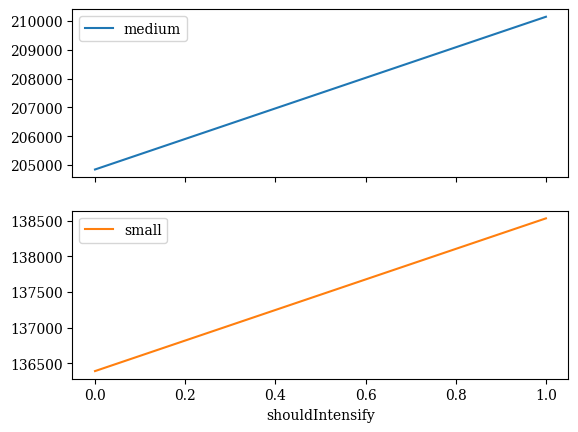

In [19]:
df.cost.groupby([df["shouldIntensify"], df["size_group"]]).mean().unstack().plot(subplots=True);

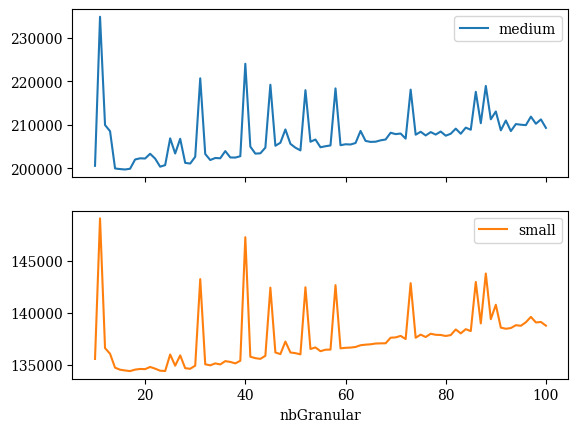

In [20]:
df.cost.groupby([df["nbGranular"], df["size_group"]]).mean().unstack().plot(subplots=True);

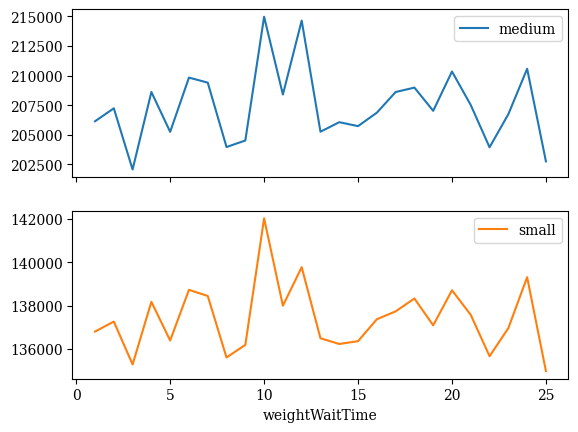

In [21]:
df.cost.groupby([df["weightWaitTime"], df["size_group"]]).mean().unstack().plot(subplots=True);

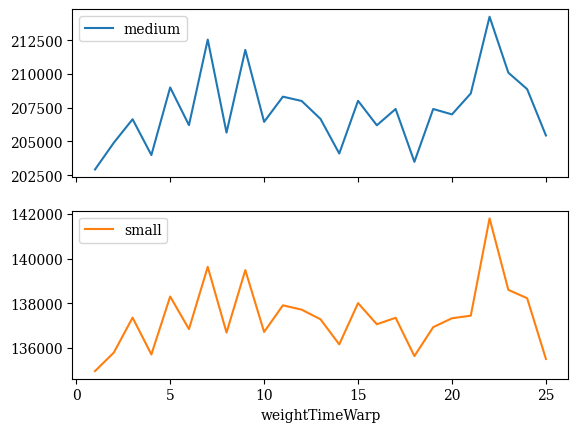

In [22]:
df.cost.groupby([df["weightTimeWarp"], df["size_group"]]).mean().unstack().plot(subplots=True);

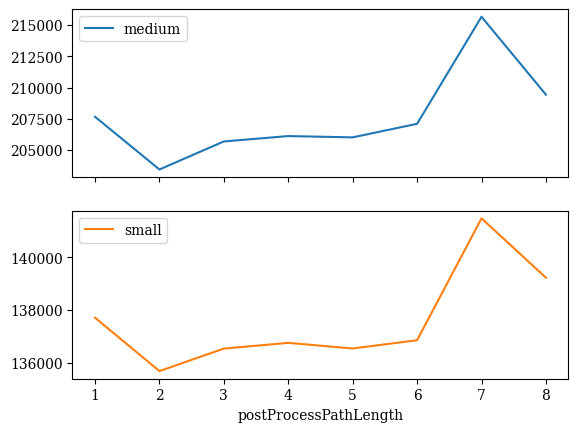

In [23]:
df.cost.groupby([df["postProcessPathLength"], df["size_group"]]).mean().unstack().plot(subplots=True);

In [24]:
mean_value = df[df.exp == 1].cost.mean()

for exp in range(1, 101):
    data = df[df.exp == exp]
    test = stats.ttest_1samp(data.cost, mean_value, alternative='less')
    mean = data.cost.mean()

    if mean <= mean_value:
        print(f"{exp:>3}  {test.pvalue:.2f}  {mean:.0f}")

  1  0.50  173827
  3  0.00  166872
  4  0.00  166904
  6  0.31  173265
  7  0.00  170662
  9  0.00  167128
 10  0.47  173742
 12  0.02  171463
 13  0.00  170828
 14  0.00  169226
 15  0.10  172377
 16  0.38  173470
 17  0.16  172700
 19  0.23  172977
 20  0.09  172326
 21  0.06  171996
 22  0.00  167716
 23  0.00  168148
 24  0.00  168781
 25  0.00  170534
 26  0.00  167579
 27  0.00  168885
 28  0.00  170781
 30  0.01  171237
 31  0.00  168805
 32  0.00  168607
 33  0.00  169228
 35  0.01  171027
 36  0.00  168170
 37  0.00  168167
 38  0.00  169295
 39  0.00  168390
 41  0.00  168001
 42  0.00  169371
 43  0.02  171559
 44  0.14  172616
 45  0.00  168101
 46  0.10  172361
 47  0.09  172340
 48  0.00  169757
 50  0.00  167070
 51  0.01  171297
 52  0.14  172602
 53  0.00  167800
 54  0.18  172791
 55  0.01  171054
 56  0.00  167684
 57  0.01  171331
 58  0.00  170664
 59  0.00  168874
 62  0.00  167290
 63  0.00  170577
 64  0.00  168146
 65  0.00  170480
 66  0.01  171145
 67  0.34 

## Dynamic solver

This part is about the static solver used to solve the eventual epoch instance. Such instances typically consist of less than 200 requests, and the solver has about 30 seconds to solve the instance well.

### Penalty parameters

This part is about the penalty parameters for the dynamic solver.

In [25]:
dfs = [read("dynamic_solver_penalty", exp) for exp in range(1, 101)]
df = pd.concat(dfs)
df.head()

,instance,seed,cost,iters,size,size_group,exp,initialTimeWarpPenalty,nbPenaltyManagement,feasBooster,penaltyIncrease,penaltyDecrease,targetFeasible,repairProbability,repairBooster
0,ORTEC-VRPTW-ASYM-9016f313-d1-n200-k20,1,174647,11832,200,small,1,1,100,2.0,1.2,0.85,0.4,50,10
1,ORTEC-VRPTW-ASYM-ef7dad5e-d1-n200-k12,1,123960,10665,200,small,1,1,100,2.0,1.2,0.85,0.4,50,10
2,ORTEC-VRPTW-ASYM-a9d4edc2-d1-n200-k15,1,147065,12827,200,small,1,1,100,2.0,1.2,0.85,0.4,50,10
3,ORTEC-VRPTW-ASYM-fd32ebe8-d1-n201-k15,1,127894,8240,201,small,1,1,100,2.0,1.2,0.85,0.4,50,10
4,ORTEC-VRPTW-ASYM-8512fc31-d1-n201-k20,1,158766,11465,201,small,1,1,100,2.0,1.2,0.85,0.4,50,10


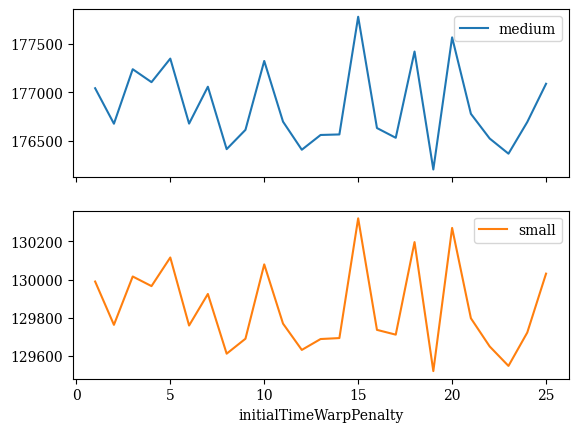

In [26]:
df.cost.groupby([df["initialTimeWarpPenalty"], df["size_group"]]).mean().unstack().plot(subplots=True);

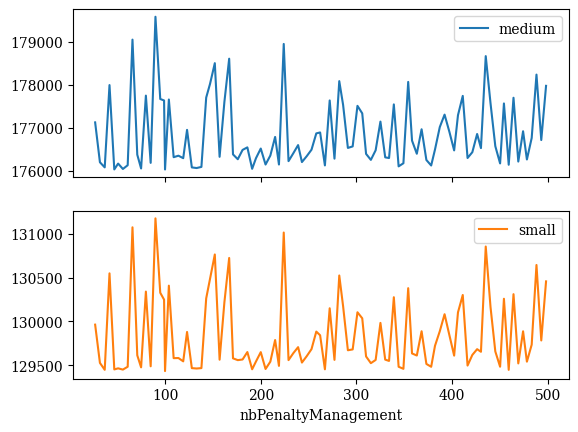

In [27]:
df.cost.groupby([df["nbPenaltyManagement"], df["size_group"]]).mean().unstack().plot(subplots=True);

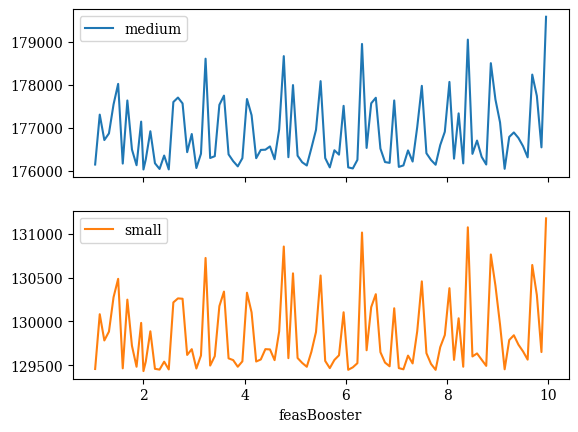

In [28]:
df.cost.groupby([df["feasBooster"], df["size_group"]]).mean().unstack().plot(subplots=True);

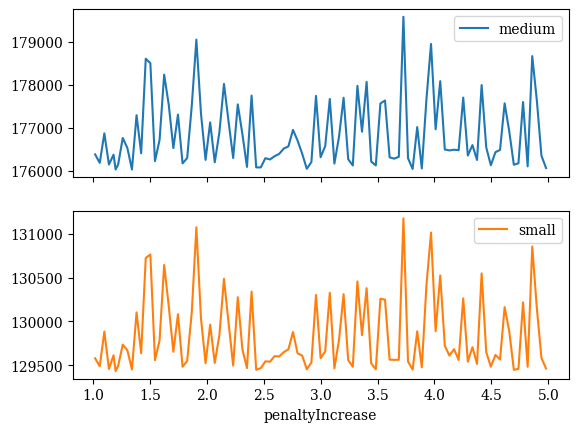

In [29]:
df.cost.groupby([df["penaltyIncrease"], df["size_group"]]).mean().unstack().plot(subplots=True);

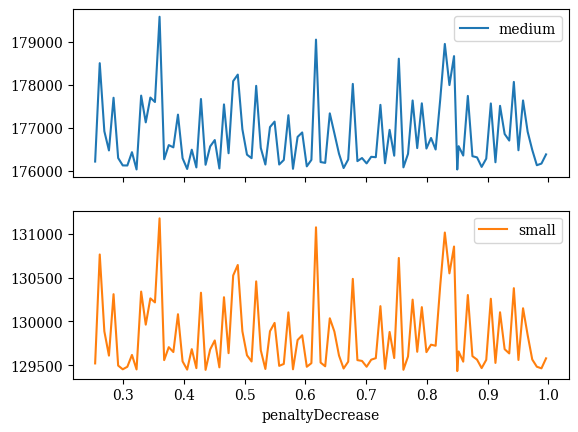

In [30]:
df.cost.groupby([df["penaltyDecrease"], df["size_group"]]).mean().unstack().plot(subplots=True);

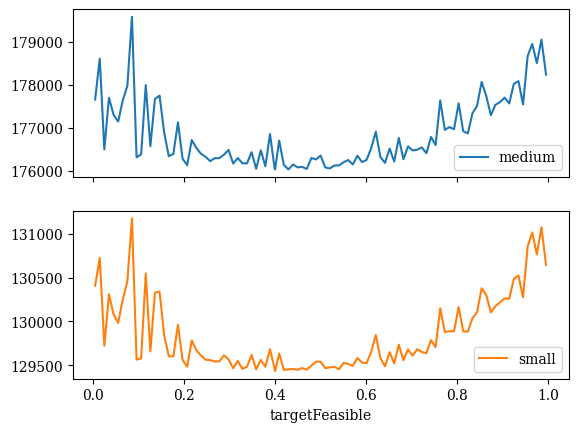

In [31]:
df.cost.groupby([df["targetFeasible"], df["size_group"]]).mean().unstack().plot(subplots=True);

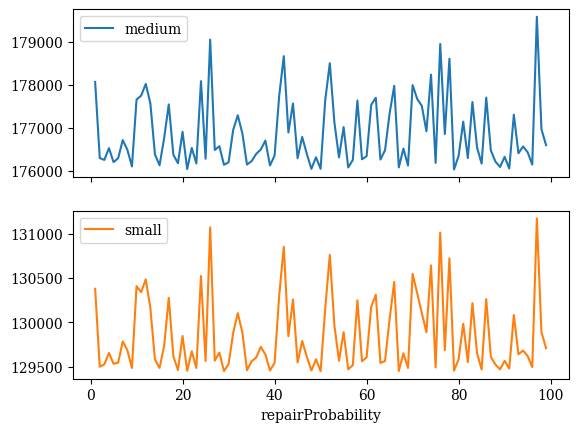

In [32]:
df.cost.groupby([df["repairProbability"], df["size_group"]]).mean().unstack().plot(subplots=True);

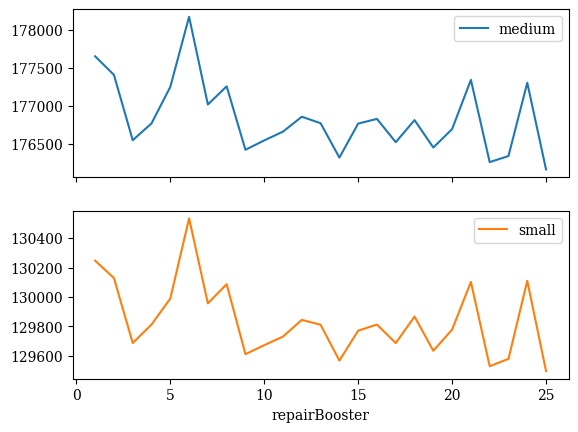

In [33]:
df.cost.groupby([df["repairBooster"], df["size_group"]]).mean().unstack().plot(subplots=True);

In [34]:
mean_value = df[df.exp == 1].cost.mean()

for exp in range(1, 101):
    data = df[df.exp == exp]
    test = stats.ttest_1samp(data.cost, mean_value, alternative='less')
    mean = data.cost.mean()

    if mean <= mean_value:
        print(f"{exp:>3}  {test.pvalue:.2f}  {mean:.0f}")

  1  0.50  148441


### Population parameters

For the dynamic solver.